<a href="https://colab.research.google.com/github/caxaxa/OB_Trading_Algo/blob/main/OB_Algo_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importin the data:

Found this data on Kaggle, with the following URL: https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data

In [ ]:
# Getting things ready to run the API for accessing the data
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets download -d martinsn/high-frequency-crypto-limit-order-book-data


100% 991M/993M [00:48<00:00, 26.5MB/s]
100% 993M/993M [00:48<00:00, 21.3MB/s]


In [ ]:
import zipfile

zip_path = '/content/high-frequency-crypto-limit-order-book-data.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Analysing the data

####Content
The dataset contains roughly 12 days of limit order book data for Bitcoin (BTC), Ethereum (ETH) and Cardano (ADA).

The data contains information for the 15 best bid / ask price levels in the order book.

####Features
midpoint = the midpoint between the best bid and the best ask

spread = the difference between the best bid and the best ask

bids_distance_x = the distance of bid level x from the midprice in %

asks_distance_x = the distance of ask level x from the midprice in %

bids_market_notional_x = volume of market orders at bid level x

bids_limit_notional_x = volume of limit orders at bid level x

bids_cancel_notional_x = volume of canceled orders at bid level x

asks_market_notional_x = volume of market orders at ask level x

asks_limit_notional_x = volume of limit orders at ask level x

asks_cancel_notional_x = volume of canceled orders at ask level x

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv('/content/BTC_1min.csv')

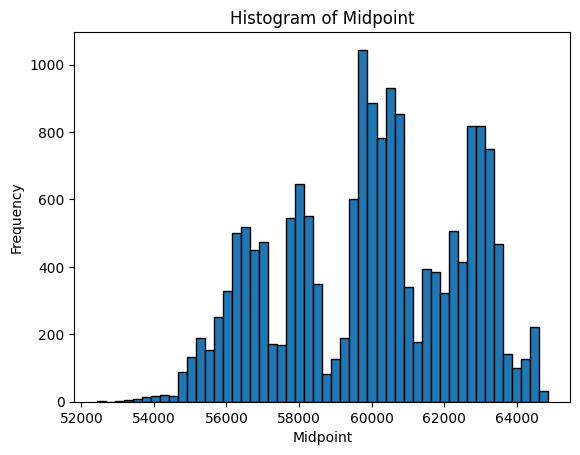

In [6]:
# Plotting the distribution:
plt.hist(df['midpoint'], bins=50, edgecolor='black')
plt.xlabel('Midpoint')
plt.ylabel('Frequency')
plt.title('Histogram of Midpoint')
plt.show()

In [7]:
# Set 'system_time' as the index of the DataFrame
df['system_time'] = pd.to_datetime(df['system_time'])
df = df.set_index('system_time')



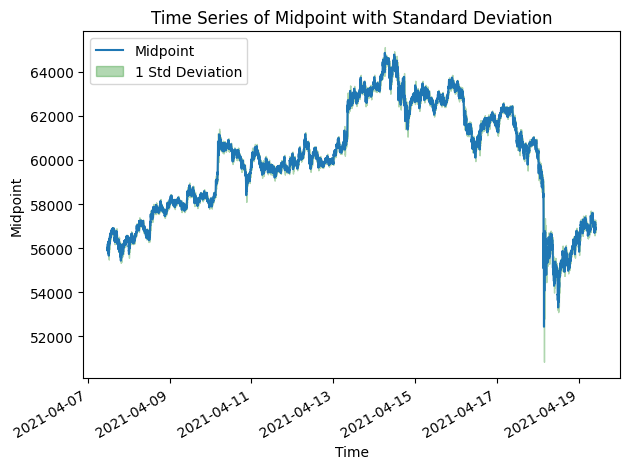

In [14]:
# Calculate the rolling standard deviation
std = df['midpoint'].rolling(window=20).std()

# Plot the time series
df['midpoint'].plot(label='Midpoint')
plt.fill_between(df.index, df['midpoint'] - std, df['midpoint'] + std, color='g', alpha=0.3, label='1 Std Deviation')


plt.xlabel('Time')
plt.ylabel('Midpoint')
plt.title('Time Series of Midpoint with Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Make a function to plot the orderbook
def plot_orderbook(data_selected, ax):

  # Extract columns related to bids and asks
  bids_cols = [f'bids_limit_notional_{i}' for i in range(15)]
  asks_cols = [f'asks_limit_notional_{i}' for i in range(15)]

  ## Get the volume for the bids and asks columns for the selected time
  bids_vol = data_selected[bids_cols].values[0][::-1]  # Reverse to stack from top down
  asks_vol = data_selected[asks_cols].values[0]
  # Create new y values from 0 to 31
  y = range(0, 31)

  # Calculate the price at each level using the mid price and distances
  bids_distances = [f'bids_distance_{i}' for i in range(15)][::-1]  # We need to reverse this list because bid levels are from top to bottom
  asks_distances = [f'asks_distance_{i}' for i in range(15)]

  # Obtain the midpoint
  mid_price = data_selected['midpoint'].values[0]

  # Calculate prices for each level
  bid_prices = mid_price * (1 + data_selected[bids_distances].values[0]/100)  # Divided by 100 because it's a percentage
  ask_prices = mid_price * (1 + data_selected[asks_distances].values[0]/100)  # Divided by 100 because it's a percentage

  # Combine bid and ask prices and round to desired decimal places
  y_tick_labels = np.round(np.concatenate((ask_prices, [mid_price], bid_prices)), 2)

  # Plot bids above midpoint, skipping the midpoint at y=15
  ax.barh(y[16:], bids_vol, color='green', alpha=0.5)  # Use only first 14 elements

  # Plot asks below midpoint, skipping the midpoint at y=15
  ax.barh(y[:15], asks_vol, color='red', alpha=0.5)

  # Plot black line at midpoint
  ax.axhline(y=15, color='black')

  ax.set_yticks(y)
  ax.set_yticklabels(y_tick_labels)  # Here we set the custom y tick labels

  ax.set_xlabel('Volume')
  ax.set_ylabel('Price')
  ax.set_title('Limit Order Book')





In [16]:
# Resample per minute and calculate mid-point
data_resampled = df.resample('60T').mean()


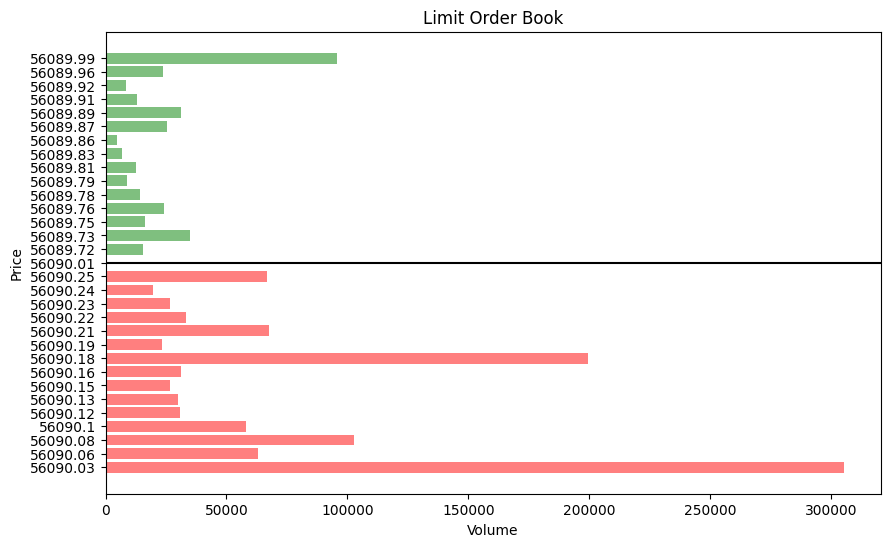

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

plot_orderbook(data_resampled.head(3), ax)

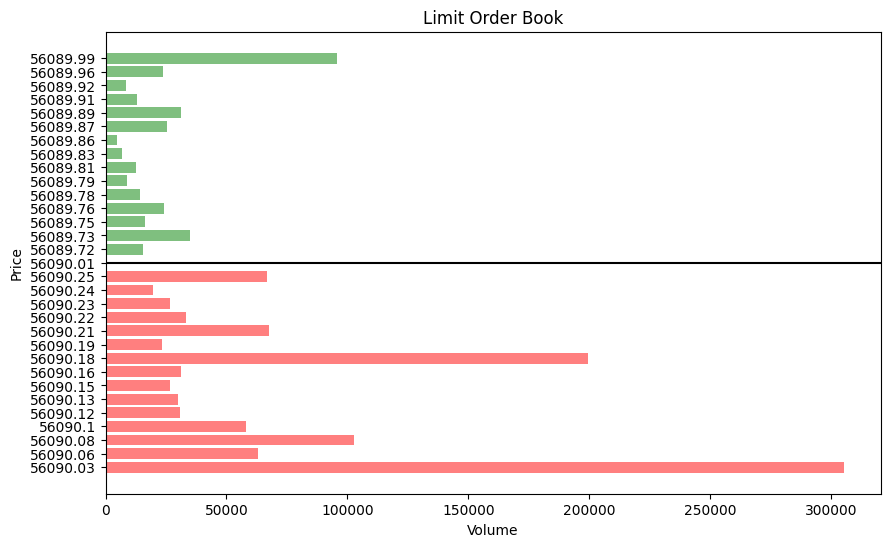

In [19]:
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10,6))

# Create animation
def update(num):
    ax.clear()  # Clear the current axes, needed for animation
    plot_orderbook(data_resampled.loc[[data_resampled.index[num]]], ax)

# adjust frames to 10 and interval to 1000ms (1 second) to make a 10-second animation
ani = animation.FuncAnimation(fig, update, frames=50, repeat=False, interval=1000)

HTML(ani.to_jshtml())
